<a href="https://colab.research.google.com/github/mit1280/fined-tuning/blob/main/kosmos2_fine_tuned_PokemonCards_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sat Apr 13 18:49:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -q -U transformers accelerate
# bitsandbytes seqeval evaluate trl peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.9 MB/s eta 0:00:00


## Compare Kosmos-2 base model vs Kosmos-2 Fine tuned model

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import requests
from datasets import load_dataset
from datasets.features import ClassLabel
import re
from PIL import Image, ImageDraw, ImageFont
import math
import random
from transformers import Kosmos2Config, Kosmos2Model, Kosmos2ForConditionalGeneration, AutoProcessor, BitsAndBytesConfig, TrainingArguments
import torch
from io import BytesIO

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
base_model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224", device_map="auto",low_cpu_mem_usage=True)
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/191k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Load model directly
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration

# processor = AutoProcessor.from_pretrained("Mit1208/Kosmos-2-PokemonCards-trl-merged")
my_model = Kosmos2ForConditionalGeneration.from_pretrained("Mit1208/Kosmos-2-PokemonCards-trl-merged", device_map="auto",low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.36k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/84.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
# Load dataset
# dataset = load_dataset("TheFusion21/PokemonCards", split="train")

Generating train split:   0%|          | 0/13139 [00:00<?, ? examples/s]

In [ ]:
prompt = "Pokemon name is"

In [ ]:
## from the database
caption = """A Stage 1 Pokemon Card of type Water with the title Wartortle and 90 HP of rarity Uncommon evolved from Squirtle from the set Team Up and the flavor text: When tapped, this Pokemon will pull in its head, but its tail will still stick out a little bit. It has the attack Tackle with the cost Colorless, Colorless, the energy cost 2 and the damage of 30. It has the attack Waterfall with the cost Water, Water, Colorless, the energy cost 3 and the damage of 70. It has weakness against Grass 2."""

In [ ]:
# load image
image_url = "https://images.pokemontcg.io/sm9/24_hires.png"
response = requests.get(image_url)
# Read the image from the response content
image = Image.open(BytesIO(response.content))


'A Stage 1 Pokemon Card of type Water with the title Wartortle and 90 HP of rarity Uncommon evolved from Squirtle from the set Team Up and the flavor text: When tapped, this Pokemon will pull in its head, but its tail will still stick out a little bit. It has the attack Tackle with the cost Colorless, Colorless, the energy cost 2 and the damage of 30. It has the attack Waterfall with the cost Water, Water, Colorless, the energy cost 3 and the damage of 70. It has weakness against Grass 2. '

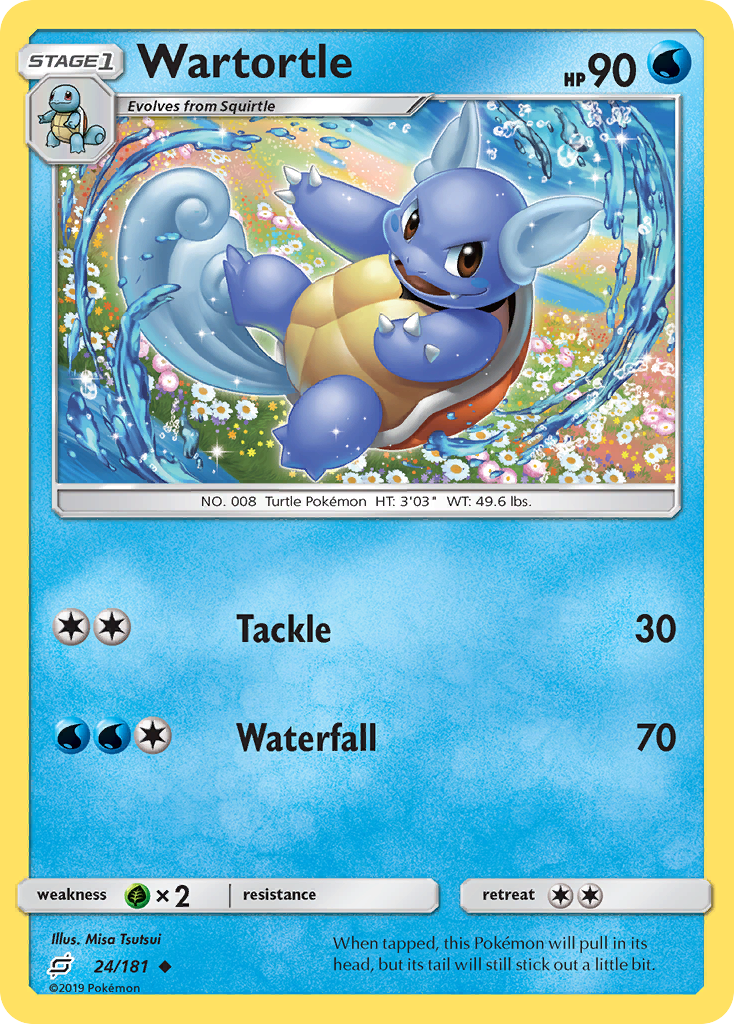

In [ ]:
image

In [ ]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0")
with torch.no_grad():
    # autoregressively generate completion
    generated_ids = my_model.generate(**inputs, max_new_tokens=30,)
# convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text.split("</image>")[-1].split(" and")[0] + ".")

 Pokemon name is Wartortle.


In [ ]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0")
with torch.no_grad():
    # autoregressively generate completion
    generated_ids = base_model.generate(**inputs, max_new_tokens=200)
# convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text.split("</image>")[-1])

 Pokemon name is Waterfall, and it's a Water Tortoise. It's also a Waterfall. It has a Water-type move, and its attack is Tackle.
